In [1]:
import qiskit
from qiskit import QuantumCircuit

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
C:\ProgramData\Anaconda3\lib\site-packages\qiskit\validation\fields\custom.py:76: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.integer, numpy.float,
C:\ProgramData\Anaconda3\lib\site-packages\qiskit\quantum_info\operators\pauli.py:111: DeprecationWarning: `np.bool` is a deprecat

In [2]:
from qiskit.transpiler.preset_passmanagers import level_2_pass_manager

In [3]:
level_2_pass_manager.run(circuit)

AttributeError: 'function' object has no attribute 'run'

In [3]:
from cirq.contrib.qasm_import import circuit_from_qasm
import cirq.contrib.routing as ccr
import cirq
import recirq
import pytket.cirq
import pytket.qasm

def read_qasm_circuit(path):
    qasm_string = open(path, 'r').read()
    try:
        return circuit_from_qasm(qasm_string)
    except:
        print('wrong circuit format')

def get_circuit_depth(circuit):
    return len(cirq.Circuit(circuit.all_operations()))

In [4]:
# 1. scale up rochester
def generate_rochester_style_device(n=1000):
    count = 9
    connection_list = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)]
    last_row_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    row_count = 1
    last_index = 8
    while count < n:
        if row_count % 2 == 1:
            if row_count == 1 or row_count % 4 == 3:
                connection_list.append((last_row_indices[0], last_index + 1))
                connection_list.append((last_row_indices[4], last_index + 2))
                connection_list.append((last_row_indices[8], last_index + 3))
                last_row_indices = [last_index + k for k in range(1, 4)]
            else:
                connection_list.append((last_row_indices[2], last_index + 1))
                connection_list.append((last_row_indices[6], last_index + 2))
                connection_list.append((last_row_indices[10], last_index + 3))
                last_row_indices = [last_index + k for k in range(1, 4)]
    
            last_index += 3
        else:
            if count + 9 >= n:
                connection_list.append((last_row_indices[0], last_index + 1))
                connection_list.append((last_row_indices[1], last_index + 5))
                connection_list.append((last_row_indices[2], last_index + 9))
                last_row_indices = [last_index + k for k in range(1, 10)]
                for k in range(1, 9):
                    connection_list.append((last_row_indices[k - 1], last_row_indices[k]))
                last_index += 9
            else:
                if row_count % 4 == 0:
                    connection_list.append((last_row_indices[0], last_index + 1))
                    connection_list.append((last_row_indices[1], last_index + 5))
                    connection_list.append((last_row_indices[2], last_index + 9))
                else:
                    connection_list.append((last_row_indices[0], last_index + 3))
                    connection_list.append((last_row_indices[1], last_index + 7))
                    connection_list.append((last_row_indices[2], last_index + 11))
                    
                last_row_indices = [last_index + k for k in range(1, 12)]
                for k in range(1, 11):
                    connection_list.append((last_row_indices[k - 1], last_row_indices[k]))
                        
                last_index += 11
                
        row_count += 1
        count += len(last_row_indices)
        
    return connection_list

            
            
        

In [5]:
import pytket
from pytket.circuit import Node
from pytket.predicates import CompilationUnit, ConnectivityPredicate
from pytket.routing import GraphPlacement
from pytket.passes import SequencePass, RoutingPass, DecomposeSwapsToCXs, PlacementPass

def _qubit_index_edges(device):
    index_to_qubit = sorted(device.qubit_set())
    qubit_to_index = {q: i for i, q in enumerate(index_to_qubit)}
    
    dev_graph = ccr.xmon_device_to_graph(device)
    for n1, n2 in dev_graph.edges:
        yield (qubit_to_index[n1], qubit_to_index[n2])

def _device_to_tket_device(device):
    arc = pytket.routing.Architecture(
        list(_qubit_index_edges(device))
    )
    print(list(_qubit_index_edges(device)))
    return pytket.device.Device({}, {}, arc)

def _device_connection_list_to_tket_device(device_connection_list):
    arc = pytket.routing.Architecture(device_connection_list)
    return pytket.device.Device({}, {}, arc)

def route_circuit_by_tket(circuit, device_connection_list):
    
    tk_circuit = circuit
    tk_device = _device_connection_list_to_tket_device(device_connection_list)
    print(tk_device)
    
    unit = CompilationUnit(tk_circuit, [ConnectivityPredicate(tk_device)])
    
    passes = SequencePass([
        PlacementPass(GraphPlacement(tk_device)),
        RoutingPass(tk_device, bridge_lookahead=0, bridge_interactions=0)]) # NO BRIDGE
    passes.apply(unit)
    valid = unit.check_all_predicates()
    
    assert valid
    
    routed_circuit = pytket.cirq.tk_to_cirq(unit.circuit)
        
    return routed_circuit

In [6]:
devices = [[(0, 1), (1, 2), (2, 3), (3, 4),
             (0, 5), (4, 6), (5, 9), (6, 13),
             (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15),
             (7, 16), (11, 17), (15, 18), (16, 19), (17, 23), (18, 27),
             (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27),
             (21, 28), (25, 29), (28, 32), (29, 36),
             (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38),
             (30, 39), (34, 40), (38, 41), (39, 42), (40, 46), (41, 50),
             (42, 43), (43, 44), (44, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50),
             (44, 51), (48, 52)]]
for i in range(1, 10):
    devices.append(generate_rochester_style_device(i * 100))

In [7]:
time.time()

NameError: name 'time' is not defined

In [11]:
import time
import os

result = {}
for i, connection_list in enumerate(devices):
    for folder in ['BNTF']:
        for file_str in os.listdir('QUEKO-benchmark/' + folder):
            start_time = time.time()
            best = int(file_str[6:8])
            circuit = read_qasm_circuit('QUEKO-benchmark/'+folder+'/'+file_str)
            routed_circuit = route_circuit_by_tket(circuit, connection_list)
            compiled = get_circuit_depth(routed_circuit)
            key = folder+'/'+device_str
            result[key] = (best, compiled, compiled / best, time.time() - start_time)
#                 print(result[key])
            print(file_str, compiled)
            q16_results[file_str] = [best, compiled, 0]

<tket::Device>


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. pytket._tket.predicates.CompilationUnit(circuit: pytket._tket.circuit.Circuit)
    2. pytket._tket.predicates.CompilationUnit(circuit: pytket._tket.circuit.Circuit, predicates: List[pytket._tket.predicates.Predicate])

Invoked with: cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.NamedQubit('q_2')),
        cirq.X(cirq.NamedQubit('q_11')),
        cirq.X(cirq.NamedQubit('q_1')),
        cirq.X(cirq.NamedQubit('q_13')),
        cirq.X(cirq.NamedQubit('q_0')),
        cirq.X(cirq.NamedQubit('q_14')),
        cirq.X(cirq.NamedQubit('q_6')),
        cirq.CNOT(cirq.NamedQubit('q_3'), cirq.NamedQubit('q_9')),
        cirq.CNOT(cirq.NamedQubit('q_8'), cirq.NamedQubit('q_12')),
        cirq.X(cirq.NamedQubit('q_7')),
        cirq.X(cirq.NamedQubit('q_4')),
        cirq.X(cirq.NamedQubit('q_15')),
    ),
    cirq.Moment(
        cirq.X(cirq.NamedQubit('q_2')),
        cirq.X(cirq.NamedQubit('q_9')),
        cirq.X(cirq.NamedQubit('q_3')),
        cirq.X(cirq.NamedQubit('q_1')),
        cirq.CNOT(cirq.NamedQubit('q_10'), cirq.NamedQubit('q_11')),
        cirq.CNOT(cirq.NamedQubit('q_8'), cirq.NamedQubit('q_12')),
        cirq.CNOT(cirq.NamedQubit('q_14'), cirq.NamedQubit('q_6')),
        cirq.CNOT(cirq.NamedQubit('q_5'), cirq.NamedQubit('q_4')),
        cirq.X(cirq.NamedQubit('q_15')),
    ),
    cirq.Moment(
        cirq.X(cirq.NamedQubit('q_1')),
        cirq.X(cirq.NamedQubit('q_12')),
        cirq.CNOT(cirq.NamedQubit('q_8'), cirq.NamedQubit('q_2')),
        cirq.CNOT(cirq.NamedQubit('q_3'), cirq.NamedQubit('q_9')),
        cirq.CNOT(cirq.NamedQubit('q_6'), cirq.NamedQubit('q_0')),
        cirq.CNOT(cirq.NamedQubit('q_14'), cirq.NamedQubit('q_10')),
    ),
    cirq.Moment(
        cirq.X(cirq.NamedQubit('q_10')),
        cirq.CNOT(cirq.NamedQubit('q_8'), cirq.NamedQubit('q_12')),
        cirq.CNOT(cirq.NamedQubit('q_14'), cirq.NamedQubit('q_6')),
        cirq.CNOT(cirq.NamedQubit('q_1'), cirq.NamedQubit('q_4')),
        cirq.X(cirq.NamedQubit('q_9')),
        cirq.X(cirq.NamedQubit('q_0')),
    ),
    cirq.Moment(
        cirq.X(cirq.NamedQubit('q_1')),
        cirq.X(cirq.NamedQubit('q_6')),
        cirq.CNOT(cirq.NamedQubit('q_8'), cirq.NamedQubit('q_12')),
        cirq.CNOT(cirq.NamedQubit('q_14'), cirq.NamedQubit('q_10')),
    ),
]), [ConnectivityPredicate:{ Nodes: 53, Edges: 58 }]

In [ ]:
list(enumerate([1,2,3,4,5]))

In [ ]:
%%time
circuit = read_qasm_circuit('QUEKO-benchmark/BSS/53QBT_700CYC_QSE_9.qasm')
routed_circuit = route_circuit_by_tket(circuit, devices[0])
print('depth = ', get_circuit_depth(routed_circuit))

In [ ]:
routed_circuit

In [12]:
get_circuit_depth(route_circuit_by_tket(circuit, devices[5]))

<tket::Device>


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. pytket._tket.predicates.CompilationUnit(circuit: pytket._tket.circuit.Circuit)
    2. pytket._tket.predicates.CompilationUnit(circuit: pytket._tket.circuit.Circuit, predicates: List[pytket._tket.predicates.Predicate])

Invoked with: cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.NamedQubit('q_2')),
        cirq.X(cirq.NamedQubit('q_11')),
        cirq.X(cirq.NamedQubit('q_1')),
        cirq.X(cirq.NamedQubit('q_13')),
        cirq.X(cirq.NamedQubit('q_0')),
        cirq.X(cirq.NamedQubit('q_14')),
        cirq.X(cirq.NamedQubit('q_6')),
        cirq.CNOT(cirq.NamedQubit('q_3'), cirq.NamedQubit('q_9')),
        cirq.CNOT(cirq.NamedQubit('q_8'), cirq.NamedQubit('q_12')),
        cirq.X(cirq.NamedQubit('q_7')),
        cirq.X(cirq.NamedQubit('q_4')),
        cirq.X(cirq.NamedQubit('q_15')),
    ),
    cirq.Moment(
        cirq.X(cirq.NamedQubit('q_2')),
        cirq.X(cirq.NamedQubit('q_9')),
        cirq.X(cirq.NamedQubit('q_3')),
        cirq.X(cirq.NamedQubit('q_1')),
        cirq.CNOT(cirq.NamedQubit('q_10'), cirq.NamedQubit('q_11')),
        cirq.CNOT(cirq.NamedQubit('q_8'), cirq.NamedQubit('q_12')),
        cirq.CNOT(cirq.NamedQubit('q_14'), cirq.NamedQubit('q_6')),
        cirq.CNOT(cirq.NamedQubit('q_5'), cirq.NamedQubit('q_4')),
        cirq.X(cirq.NamedQubit('q_15')),
    ),
    cirq.Moment(
        cirq.X(cirq.NamedQubit('q_1')),
        cirq.X(cirq.NamedQubit('q_12')),
        cirq.CNOT(cirq.NamedQubit('q_8'), cirq.NamedQubit('q_2')),
        cirq.CNOT(cirq.NamedQubit('q_3'), cirq.NamedQubit('q_9')),
        cirq.CNOT(cirq.NamedQubit('q_6'), cirq.NamedQubit('q_0')),
        cirq.CNOT(cirq.NamedQubit('q_14'), cirq.NamedQubit('q_10')),
    ),
    cirq.Moment(
        cirq.X(cirq.NamedQubit('q_10')),
        cirq.CNOT(cirq.NamedQubit('q_8'), cirq.NamedQubit('q_12')),
        cirq.CNOT(cirq.NamedQubit('q_14'), cirq.NamedQubit('q_6')),
        cirq.CNOT(cirq.NamedQubit('q_1'), cirq.NamedQubit('q_4')),
        cirq.X(cirq.NamedQubit('q_9')),
        cirq.X(cirq.NamedQubit('q_0')),
    ),
    cirq.Moment(
        cirq.X(cirq.NamedQubit('q_1')),
        cirq.X(cirq.NamedQubit('q_6')),
        cirq.CNOT(cirq.NamedQubit('q_8'), cirq.NamedQubit('q_12')),
        cirq.CNOT(cirq.NamedQubit('q_14'), cirq.NamedQubit('q_10')),
    ),
]), [ConnectivityPredicate:{ Nodes: 502, Edges: 571 }]

In [13]:
get_circuit_depth(routed_circuit2)

NameError: name 'routed_circuit2' is not defined

In [14]:
route_circuit_by_tket(circuit, meow)

NameError: name 'meow' is not defined

In [15]:
wtf = [(0, 6), (1, 6), (1, 7), (2, 7), (2, 8), (3, 8), (3, 9), (4, 9), (4, 10), (5, 10), (5, 11),
                                    (6, 12), (6, 13), (7, 13), (7, 14), (8, 14), (8, 15), (9, 15), (9, 16), (10, 16), (10, 17), (11, 17),
                                    (12, 18), (13, 18), (13, 19), (14, 19), (14, 20), (15, 20), (15, 21), (16, 21), (16, 22), (17, 22), (17, 23),
                                    (18, 24), (18, 25), (19, 25), (19, 26), (20, 26), (20, 27), (21, 27), (21, 28), (22, 28), (22, 29), (23, 29),
                                    (24, 30), (25, 30), (25, 31), (26, 31), (26, 32), (27, 32), (27, 33), (28, 33), (28, 34), (29, 34), (29, 35),
                                    (30, 36), (30, 37), (31, 37), (31, 38), (32, 38), (32, 39), (33, 39), (33, 40), (34, 40), (34, 41), (35, 41),
                                    (36, 42), (37, 42), (37, 43), (38, 43), (38, 44), (39, 44), (39, 45), (40, 45), (40, 46), (41, 46), (41, 47),
                                    (42, 48), (42, 49), (43, 49), (43, 50), (44, 50), (44, 51), (45, 51), (45, 52), (46, 52), (46, 53), (47, 53), (53, 54), (54, 55), (55, 56)]

In [16]:
meow = [(a, a+1) for a in range(203)]

In [17]:
djs = [i for i in range(203)]
def get_set(k):
    if djs[k] == k: return k
    else:
        djs[k] = get_set(djs[k])
        return djs[k]
def unite(a, b):
    djs[get_set(b)] = get_set(a)
    
for a, b in devices[1]:
    unite(a, b)

for i in range(203):
    print(get_set(i), end=' ')

68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 

In [18]:
routed_circuit2

NameError: name 'routed_circuit2' is not defined

In [ ]:
circuit = pytket.qasm.circuit_from_qasm('QUEKO-benchmark/BSS/53QBT_700CYC_QSE_9.qasm')
tk_circuit = circuit
tk_device = _device_connection_list_to_tket_device(generate_rochester_style_device(80))
unit = CompilationUnit(tk_circuit, [ConnectivityPredicate(tk_device)])
passes = SequencePass([
        PlacementPass(GraphPlacement(tk_device)),
        RoutingPass(tk_device, swap_lookahead=30)]) # NO BRIDGE
passes.apply(unit)

In [20]:
dev = generate_rochester_style_device(80)

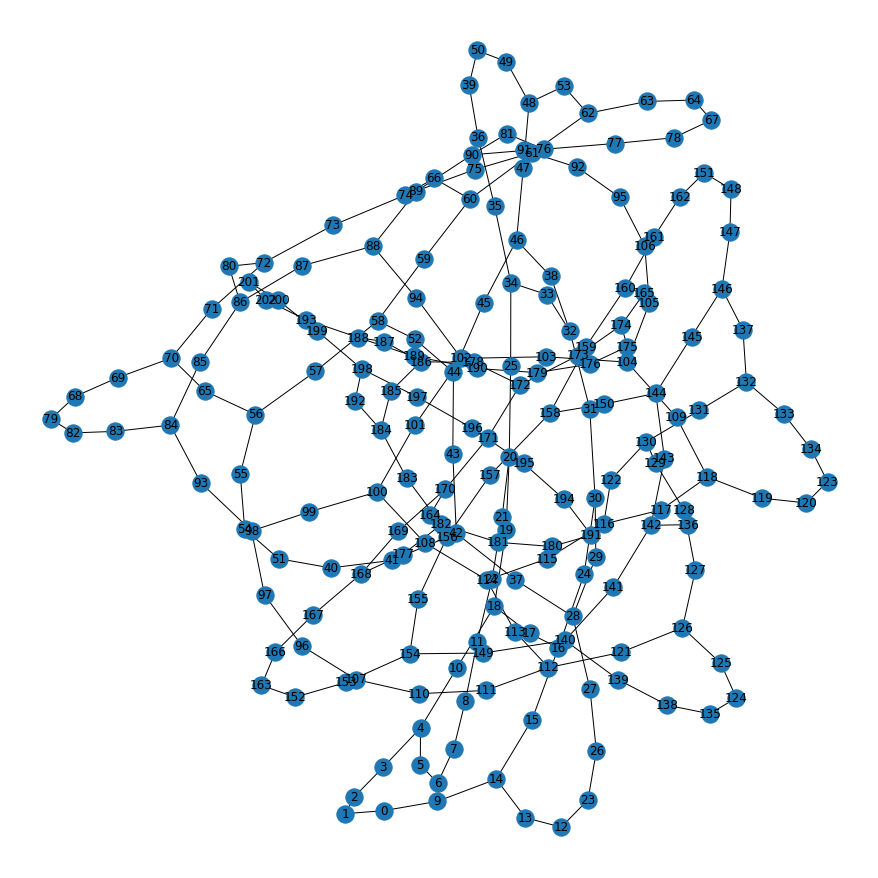

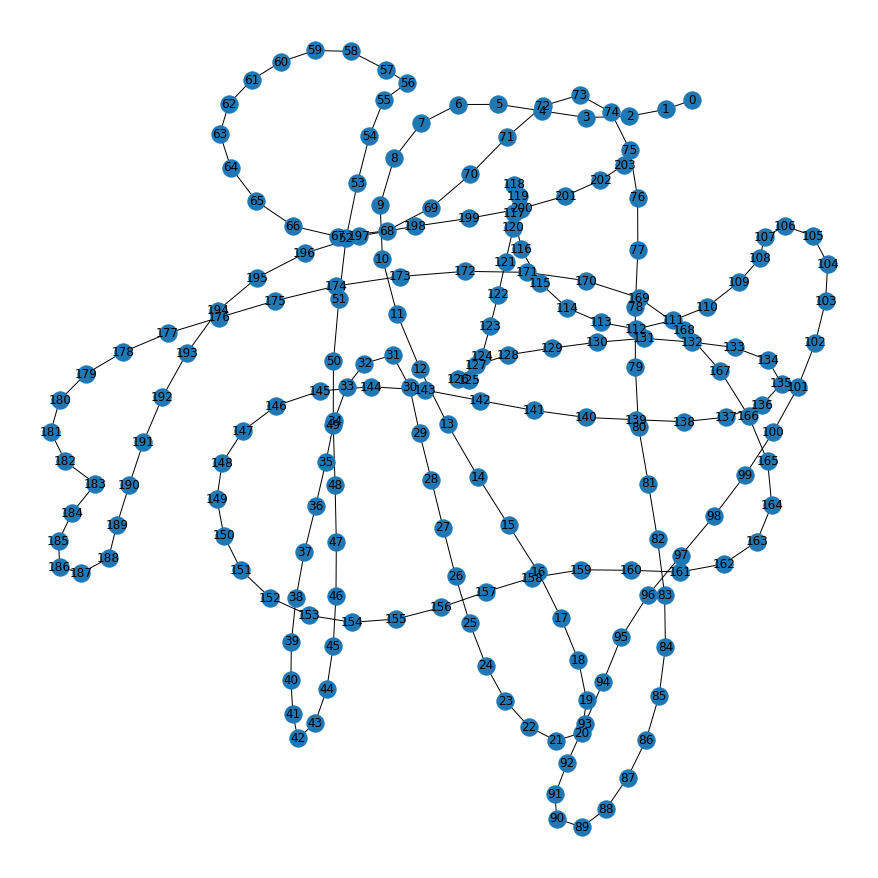

In [72]:

import networkx as nx
import matplotlib.pyplot as plt


def draw_graph(coupling_map):
    plt.figure(figsize=(12,12))
    coupling_graph = nx.Graph(coupling_map)
    nx.draw_spring(coupling_graph, labels={node: node for node in coupling_graph.nodes()})
    
draw_graph(devices[1])
draw_graph(meow)

In [21]:
import qiskit.circuit.library
def QFT(n=5):
    return qiskit.circuit.library.QFT(n)

In [40]:
f_out = open('qft25.qasm', 'w')
f_out.write(QFT(25).qasm())
f_out.close()

In [44]:
tk_circuit = pytket.qasm.circuit_from_qasm('qft25.qasm')
print(tk_circuit.n_qubits, tk_circuit.n_gates)

25 337


In [42]:

get_circuit_depth(route_circuit_by_tket(pytket.qasm.circuit_from_qasm('qft25.qasm'), devices[5]))

<tket::Device>


142

In [24]:
import re

In [ ]:
result = []
for i in range(1, 21):
    f_path = f'QFT/qft{i*50}.qasm'
    f_out = open(f_path, 'w')
    f_out.write(re.sub(r'cu1\(pi/\d+\)', 'cu1(pi/2)', QFT(i*50).qasm()))
    f_out.close()
    for device in devices:
        depth = -1
        tk_circuit = pytket.qasm.circuit_from_qasm(f_path)
        try:
            depth = get_circuit_depth(route_circuit_by_tket(tk_circuit, device))
        except:
            pass
        result.append((tk_circuit.n_qubits, tk_circuit.n_gates, depth))

<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Device>
<tket::Dev

In [41]:

mapping = [i for i in range(100)]
shuffle(mapping)

In [45]:
from random import random, randint, shuffle

def generate_benchmark_circuit(connection_list, max_depth, d1=0.5, d2=0.5):
    # read connection list
    n = 0
    for a, b in connection_list: n = max(n, max(a+1, b+1))
    graph = [[] for i in range(n)]
    for a, b in connection_list:
        graph[a].append(b)
        graph[b].append(a)
        
    # random mapping
    mapping = [i for i in range(n)]
    shuffle(mapping)
        
    circuit = QuantumCircuit(n)
    c1 = int(max_depth * d1)
    c2 = max_depth - c1
    t1, t2 = 0, 0
    
    k = randint(0, n-1)
    
    for i in range(max_depth):
        r = random()
        if r < d1 and t1 < c1 or t2 >= c2:
            circuit.h(mapping[k])
            t1 += 1
        else:
            r_edge = graph[k][randint(0, len(graph[k]) - 1)]
            circuit.cx(mapping[r_edge], mapping[k])
            t2 += 1
            
    t1, t2 = 0, 0
    
    for i in range(max_depth):
        r = random()
        if r < d1 and t1 < c1 or t2 >= c2:
            r_node = randint(0, n - 1)
            if r_node == k: continue
            circuit.h(mapping[r_node])
            t1 += 1
        else:
            r_node = randint(0, n - 1)
            r_edge = graph[r_node][randint(0, len(graph[r_node]) - 1)]
            if r_edge == k or r_node == k: continue
            circuit.cx(mapping[r_node], mapping[r_edge])
            t2 += 1
    
    return circuit

In [46]:
circ = generate_benchmark_circuit(devices[1], max_depth=1000)

In [48]:
for i, device in enumerate(devices):
    for max_depth in [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]:
        temp_circuit = generate_benchmark_circuit(device, max_depth=max_depth)
        with open(f'scaling/{i}_{max_depth}.qasm', 'w') as file:
            file.write(temp_circuit.qasm())
        

In [ ]:
import time
result = []
for i, device in enumerate(devices):
    for max_depth in [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]:
        now = time.time()
        f_path = f'scaling/{i}_{max_depth}.qasm'
        depth = -1
        tk_circuit = pytket.qasm.circuit_from_qasm(f_path)
#         depth = get_circuit_depth(route_circuit_by_tket(tk_circuit, device))
        try:
            depth = get_circuit_depth(route_circuit_by_tket(tk_circuit, device))
        except:
            pass
        print(tk_circuit.n_qubits, tk_circuit.n_gates, depth, max_depth, time.time() - now)
        result.append((tk_circuit.n_qubits, tk_circuit.n_gates, depth, max_depth, time.time() - now))

<tket::Device>
53 393 213 200 1.4821367263793945
<tket::Device>
53 789 431 400 0.6533327102661133
<tket::Device>
53 1189 729 600 0.7651355266571045
<tket::Device>
53 1573 854 800 1.2792949676513672
<tket::Device>


In [19]:
import random

def edge_to_adj_list(edge_list):
    node_count = 0
    for a, b in edge_list:
        node_count = max(node_count, a)
        node_count = max(node_count, b)
    node_count += 1 # 0-based
    adj_list = [[] for i in range(node_count)]
    
    for a, b in edge_list:
        adj_list[a].append(b)
        adj_list[b].append(a)
        
    return adj_list
    

def FM_cut(adj_list):
    node_count = len(adj_list)
    
    node_list = [k for k in range(node_count)]
    random.shuffle(node_list) # shuffle and bi-sec
    in_set = [0 for k in range(node_count)]
    set_A = node_list[:node_count // 2]
    set_B = node_list[node_count // 2:]
    
    for node in set_B: in_set[node] = 1
    A = len(set_A)
    B = len(set_B)
    
    total_cost = 0
    for i in range(node_count):
        for v in adj_list[i]:
            if in_set[v] != in_set[i]: total_cost += 1
                
    print('initial cost =', total_cost)
        
    moved = [False for k in range(node_count)]    
        
    # this can be optimized to avoid duplicated nodes
    while True:
        node_to_move = -1
        best_improve = 0
        for i in range(node_count):
            if moved[i]: continue
            if A > B and in_set[i] == 1: continue
            if B > A and in_set[i] == 0: continue
            temp = 0
            for v in adj_list[i]:
                if in_set[v] != in_set[i]: temp += 1
                else: temp -= 1
#             print('temp', i, temp)
            if temp > best_improve:
#                 print('improve!')
                node_to_move = i
                best_improve = temp
        
        if node_to_move < 0: break
            
        if in_set[i] == 0:
            A -= 1
            B += 1
            in_set[i] = 1
        else:
            A += 1
            B -= 1
            in_set[i] = 0
            
        print('USE THIS', node_to_move, best_improve)
        
    total_cost = 0
    for i in range(node_count):
        for v in adj_list[i]:
            if in_set[v] != in_set[i]: total_cost += 1

    return total_cost / 2
    
    
    
    
        
    

In [20]:
adj_list = edge_to_adj_list(devices[0])
FM_cut(adj_list)

initial cost = 44
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
US

USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE TH

USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE TH

USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE TH

USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE TH

USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE TH

USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE TH

USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE TH

USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE THIS 37 2
USE THIS 38 2
USE TH

KeyboardInterrupt: 

In [ ]:
device_connection_list = [(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (0, 9),
 (4, 10),
 (8, 11),
 (9, 14),
 (10, 18),
 (11, 22),
 (12, 13),
 (13, 14),
 (14, 15),
 (15, 16),
 (16, 17),
 (17, 18),
 (18, 19),
 (19, 20),
 (20, 21),
 (21, 22),
 (12, 23),
 (16, 24),
 (20, 25),
 (23, 26),
 (24, 30),
 (25, 34),
 (26, 27),
 (27, 28),
 (28, 29),
 (29, 30),
 (30, 31),
 (31, 32),
 (32, 33),
 (33, 34),
 (34, 35),
 (35, 36),
 (28, 37),
 (32, 38),
 (36, 39),
 (37, 42),
 (38, 46),
 (39, 50),
 (40, 41),
 (41, 42),
 (42, 43),
 (43, 44),
 (44, 45),
 (45, 46),
 (46, 47),
 (47, 48),
 (48, 49),
 (49, 50),
 (40, 51),
 (44, 52),
 (48, 53),
 (51, 54),
 (52, 58),
 (53, 62),
 (54, 55),
 (55, 56),
 (56, 57),
 (57, 58),
 (58, 59),
 (59, 60),
 (60, 61),
 (61, 62),
 (62, 63),
 (63, 64),
 (56, 65),
 (60, 66),
 (64, 67),
 (65, 70),
 (66, 74),
 (67, 78),
 (68, 69),
 (69, 70),
 (70, 71),
 (71, 72),
 (72, 73),
 (73, 74),
 (74, 75),
 (75, 76),
 (76, 77),
 (77, 78),
 (68, 79),
 (72, 80),
 (76, 81)]